This notebook build predictive models for each municipality

In [302]:
#importer libraries
from sklearn.metrics import mean_squared_error
import os
import tqdm as tqdm
import re
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import GridSearchCV, learning_curve, KFold, train_test_split
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import KFold, train_test_split

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

from sklearn.metrics import mean_squared_error as mse

from sklearn.exceptions import ConvergenceWarning


import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [303]:
# imports function to add features to data.
%run "add_features_to_data.py"




A function for fitting a model is made. This function takes a dataset of cleaned Boliga data, and enrich it with the selected features.

In [304]:
def make_a_model(data):
    # splitting data in target values (y) and features (X)
    y = data["avg_sqm_price"]
    X = data.drop(columns=["avg_sqm_price"])
    
    # numeric and categorical features are identified
    numeric_features = X.select_dtypes(include = ["number"]).columns.tolist()
    categorical_features = X.select_dtypes(include=["category"]).columns.tolist()
    
    # Data is split into test and training data, stratified on housing_type
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(.2), random_state=47, stratify=X["housing_type"])
    
    # Known categories in the categorical data are identified and stored for use in OneHotEncoder
    known_categories = [X[i].unique().tolist() for i in X.select_dtypes(include=["category"]).columns.tolist()]
    
    # Preprocessor defined. Numerical features are scaled, and categorical values OneHotEncoded with the
    # known categories
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), numeric_features),
        ('cat', OneHotEncoder(categories=known_categories), categorical_features)
    ])

    # The training pipeline is defined. Preprocessing as defined above, polynomial feature expansion
    # and Elastic Net as the classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('polynomial', PolynomialFeatures(degree=3)),  # Tilføj denne linje
        ('classifier', ElasticNet())
    ])

    # Paramergrid defined for the gridsearch
    param_grid = {
        'polynomial__degree': [1, 2, 3],  # Ny linje for at prøve forskellige polynomial grader
        'classifier__alpha': np.logspace(-4, 4, 12),
        'classifier__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        'classifier__max_iter': [2000] 
    }
    # Setting up the GridSearch with pipeline and parametergrid. 5-fold crossvalidation 
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    
    # Searching for optimal hyperparameters.
    grid_search.fit(X_train, y_train)
    
    # grabbing information about the result
    best_parameters = grid_search.best_params_
    best_pipeline = grid_search.best_estimator_
    y_pred = best_pipeline.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = best_pipeline.score(X_test, y_test)
    coefficients = best_pipeline.named_steps['classifier'].coef_

    # Grabbing names and weights of the polynomial features.
    # First, get names of both numeric and categorical features
    numeric_feature_names = numeric_features
    categorical_feature_names = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

    # Now the polynomial feature names
    polynomial_feature_names = best_pipeline.named_steps['polynomial'].get_feature_names_out(input_features=all_feature_names)

    # Combining to one object
    coefs =  zip(coefficients, polynomial_feature_names)
    
    # gets data for a learning curve
    train_sizes, train_scores, test_scores = learning_curve(estimator=best_pipeline,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=10)
    
    learning_curve_data = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1),
                     'sample size':train_sizes})
    
    # Finally return fitted models, parameters, metrics, coefficients and data for a learning curve
    return (grid_search, best_parameters, rmse, r2, coefs, learning_curve_data)

    

In [305]:
# Getting aggregated data stored as csv's
fp = Path("../Daniel/agg_data/")
files = list(fp.glob('*.csv'))

# initialising dataframes for saving results of the fits
metrics = pd.DataFrame(columns=['muni_code', 'rmse', 'r2'])
fitted_models = pd.DataFrame(columns=['muni_code', 'pickled_model'])
learning_curves = pd.DataFrame(columns=['muni_code',  "Train","Test", "sample size"])
coefficients = pd.DataFrame(columns=['muni_code', 'value', 'parameter'])
parameters = pd.DataFrame(columns=['muni_code', 'Parameter', 'Value']) 

# running the loop for modelling
for filename in tqdm.tqdm(files):
    muni_code = re.search(r'(\d+)\.csv$', str(filename)).group(1) # extracting muni_code
    data = pd.read_csv(filename) # reading data
    data = add_features_to_data(data) # feature adding
    data = data.drop(columns=["year", "muni_code"]) # dropping columns
    grid_search, best_parameters, rmse, r2, coefs, learning_curve_data = make_a_model(data)
    
    # saving pickled models
    rick = pickle.dumps(grid_search)
    model_row = pd.DataFrame({'muni_code': [muni_code],
             'pickled_model':[rick]})
    fitted_models = fitted_models.append(model_row, ignore_index = True)
    
    # saving metrics
    metric_tuple = (muni_code, rmse, r2)
     # Konverter tuple til DataFrame
    metric_row = pd.DataFrame([metric_tuple], columns=metrics.columns)
    # Append til den eksisterende DataFrame
    metrics = metrics.append(metric_row, ignore_index = True)
    
    # saving parameters
    param_row = pd.DataFrame(list(best_parameters.items()), columns=['Parameter', 'Value'])
    param_row['muni_code'] = muni_code
    # append
    parameters = parameters.append(param_row, ignore_index = True)
    # saving coefficients
    coef_row = pd.DataFrame(coefs, columns = ['value', 'parameter'])
    coef_row['muni_code'] = muni_code
    coefficients = coefficients.append(coef_row, ignore_index = True)
    # saving learning curve data
    learning_curve_data['muni_code'] = muni_code
    learning_curves = learning_curves.append(learning_curve_data, ignore_index = True)
    
   

0it [00:00, ?it/s]


In [299]:

# fitted_models 

parameters.to_csv("parameter_demo.csv")
coefficients.to_csv("coefficients_demo.csv")
metrics.to_csv("metrics_demo.csv")
learning_curves.to_csv("learning_curves_demo.csv")
fitted_models.to_csv("fitted_models_demo.csv")
parameters.to_csv("parameters_demo.csv")

,Parameter,Value
0,classifier__alpha,2.31013
1,classifier__l1_ratio,0.30000
2,classifier__max_iter,1500.00000
3,polynomial__degree,2.00000


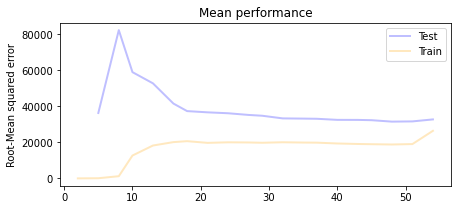

In [110]:
def learning_curve_plot(tester):
    f_learn, ax = plt.subplots(figsize=(7,3))
    ax.plot(tester["sample size"],np.sqrt(tester["Test"]), alpha=0.25, linewidth=2, label ='Test', color='blue') # negated, because we already use neg_MSE
    ax.plot(tester["sample size"],np.sqrt(tester["Train"]), alpha=0.25, linewidth=2, label='Train', color='orange') # negated, because we already use neg_MSE

    ax.set_title('Mean performance')
    ax.set_ylabel('Root-Mean squared error')
    ax.legend();
learning_curve_plot(tester)